In [1]:
import MotifCompendium
import MotifCompendium.utils.analysis as utils_analysis
import MotifCompendium.utils.motif as utils_motif
from MotifCompendium.utils.similarity import set_default_options
from IPython.display import display, HTML, Image
import pandas as pd
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import scipy.cluster.hierarchy as sch
from scipy.stats import zscore
from sklearn.preprocessing import quantile_transform
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

In [2]:
# Directory containing the data
data_dir = '/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks'
table_dir = '/oak/stanford/groups/akundaje/projects/neuro-variants/tables'
plot_dir = '/oak/stanford/groups/akundaje/projects/neuro-variants/plots/motifs'
motif_file_name = "hits_unique.tsv"

fold = 'mean'
score_type = 'counts'
alpha = 'alpha_0.8'
leiden = 'leiden_96'

In [3]:
mc = MotifCompendium.load('/oak/stanford/groups/akundaje/projects/neuro-variants/motif_compendium/all_data/'
                          + leiden + '/neuro-variants.all_data.motif_compendium.' + leiden + '.mc')

mc['original_pattern'] = mc['name'].str.split('-').str[1].str.split('.').str[0] + '_patterns.' + mc['name'].str.split('.').str[-1]
mc_metadata = mc.metadata.copy()
mc_metadata = mc_metadata[['model', 'original_pattern', leiden, 'annotation']]

mc_metadata

,model,original_pattern,leiden_96,annotation
0,trevino_2021.c20,pos_patterns.pattern_0,10,NFI-1_10
1,trevino_2021.c20,pos_patterns.pattern_1,5,CTCF-1_5
2,trevino_2021.c20,pos_patterns.pattern_10,2,BZIP:ATF-CREB-1_2
3,trevino_2021.c20,pos_patterns.pattern_11,7,ETS:ELF-ETV-1_7
4,trevino_2021.c20,pos_patterns.pattern_12,3,ZNF143-1_3
...,...,...,...,...
2483,corces_2020.Cluster24,pos_patterns.pattern_6,99,IRF-STAT_IRF-STAT-1_99
2484,corces_2020.Cluster24,pos_patterns.pattern_7,4,NFY_4
2485,corces_2020.Cluster24,pos_patterns.pattern_8,19,BZIP:ATF-CREB-1_19
2486,corces_2020.Cluster24,pos_patterns.pattern_9,10,NFI-1_10


In [4]:
mc_avg = MotifCompendium.load('/oak/stanford/groups/akundaje/projects/neuro-variants/motif_compendium/all_data/'
                                + leiden + '/neuro-variants.all_data.motif_compendium.avg.' + leiden + '.mc')

mc_avg.metadata

,index,name,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,hocomoco_similarity,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,annotation
0,0,pos_patterns.pattern_0,74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.914414,NRF1.H12CORE.0.PS.A,0.951238,NRF1_M09443_2.00,0.998523,NRF1,NRF1_0
1,1,pos_patterns.pattern_1,58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.969925,SP4.H12CORE.0.P.C,0.944662,SP4_M08296_2.00,0.998351,SP/KLF,SP-KLF_1
2,2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.937175,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,BZIP:ATF-CREB-1_2
3,3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.981210,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,ZNF143-1_3
4,4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.978794,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,NFY_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,pos_patterns.pattern_720,1,28,1,1,corces_2020,pos,0.912841,RFX1.H12CORE.1.PSM.A,0.922637,RFX2_M09362_2.00,0.962012,RFX#1,RFX-1_994
995,995,pos_patterns.pattern_721,1,27,1,1,corces_2020,pos,0.908444,CEBPD.H12CORE.0.P.B,0.907553,CEBPA_M08813_2.00,0.930452,BZIP:CEBP#1,Unknown_995
996,996,pos_patterns.pattern_722,1,26,1,1,corces_2020,pos,0.898491,MITF.H12CORE.0.P.B,0.854161,ZNF317_M08308_2.00,0.888819,BHLH:USF1/2#1,Unknown_996
997,997,pos_patterns.pattern_723,1,24,1,1,corces_2020,pos,0.901590,RUNX2.H12CORE.0.P.B,0.919790,RUNX3_M02751_2.00,0.937730,RUNX#1,Unknown_997


In [5]:
# Define the entropy metrics we want to calculate
entropy_list = [
    "motif_entropy",
    "posbase_entropy_ratio",
    "copair_entropy_ratio",
    "dinuc_entropy_ratio"
]

# Calculate entropy metrics
utils_analysis.calculate_entropy(
    mc_avg,
    entropy_list=entropy_list
)

mc_avg.metadata.rename(columns={'index': leiden,
                                'name': 'clustered_pattern'},
                                inplace=True)

mc_avg.metadata

,leiden_96,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,hocomoco_similarity,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,annotation,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio
0,0,pos_patterns.pattern_0,74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.914414,NRF1.H12CORE.0.PS.A,0.951238,NRF1_M09443_2.00,0.998523,NRF1,NRF1_0,0.516517,1.488471,2.845492,1.543807
1,1,pos_patterns.pattern_1,58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.969925,SP4.H12CORE.0.P.C,0.944662,SP4_M08296_2.00,0.998351,SP/KLF,SP-KLF_1,0.510798,1.639470,1.740413,2.061026
2,2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.937175,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,BZIP:ATF-CREB-1_2,0.506504,1.554268,1.292231,1.127238
3,3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.981210,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,ZNF143-1_3,0.567049,1.301145,1.474322,1.445198
4,4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.978794,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,NFY_4,0.487531,1.653990,1.526165,1.144037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,pos_patterns.pattern_720,1,28,1,1,corces_2020,pos,0.912841,RFX1.H12CORE.1.PSM.A,0.922637,RFX2_M09362_2.00,0.962012,RFX#1,RFX-1_994,0.572708,1.632554,1.447394,1.284123
995,995,pos_patterns.pattern_721,1,27,1,1,corces_2020,pos,0.908444,CEBPD.H12CORE.0.P.B,0.907553,CEBPA_M08813_2.00,0.930452,BZIP:CEBP#1,Unknown_995,0.540519,1.222717,1.552044,1.223956
996,996,pos_patterns.pattern_722,1,26,1,1,corces_2020,pos,0.898491,MITF.H12CORE.0.P.B,0.854161,ZNF317_M08308_2.00,0.888819,BHLH:USF1/2#1,Unknown_996,0.560141,1.232628,1.442505,1.137544
997,997,pos_patterns.pattern_723,1,24,1,1,corces_2020,pos,0.901590,RUNX2.H12CORE.0.P.B,0.919790,RUNX3_M02751_2.00,0.937730,RUNX#1,Unknown_997,0.577830,1.494380,1.518736,1.522029


In [6]:
# # Define entropy metric thresholds, per archetype
# entropy_filter_dict ={
#     "1_singlepeak": {
#         "metric": "motif_entropy",
#         "operation": "<",
#         "threshold": 0.4,
#     },
#     "2_noisemix": {
#         "metric": "motif_entropy",
#         "operation": ">",
#         "threshold": 0.6,
#     },
#     "3_broadsingle": {
#         "metric": "posbase_entropy_ratio",
#         "operation": ">",
#         "threshold": 1.5,
#     },
#     "4_gcbias": {
#         "metric": "copair_entropy_ratio",
#         "operation": ">",
#         "threshold": 1.5,
#         "override": False
#     },
#     "5_dinucrepeat": {
#         "metric": "dinuc_entropy_ratio",
#         "operation": ">",
#         "threshold": 1.7,
#     }
# }

# # Check if motif falls under each archetype, based on the entropy metrics
# for filter_name, filter_dict in entropy_filter_dict.items():
#     metric = filter_dict["metric"]
#     threshold = filter_dict["threshold"]
#     operation = filter_dict["operation"]

#     if operation == "<":
#         mc_avg[filter_name] = (mc_avg[metric] < threshold)
#     elif operation == "<=":
#         mc_avg[filter_name] = (mc_avg[metric] <= threshold)
#     elif operation == ">":
#         mc_avg[filter_name] = (mc_avg[metric] > threshold)
#     elif operation == ">=":
#         mc_avg[filter_name] = (mc_avg[metric] >= threshold)
#     elif operation == "==":
#         mc_avg[filter_name] = (mc_avg[metric] == threshold)
#     elif operation == "!=":
#         mc_avg[filter_name] = (mc_avg[metric] != threshold)
#     else:
#         raise ValueError(f"Invalid operation: {filter_dict[operation]}")

# # Filter if motif falls under any archetype
# mc_avg.metadata["entropy_filter"] = mc_avg.metadata[entropy_filter_dict.keys()].all(axis=1)

# mc_avg.metadata

In [7]:
mc_avg_metadata = mc_avg.metadata.copy()

mc_avg_metadata

,leiden_96,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,hocomoco_similarity,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,annotation,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio
0,0,pos_patterns.pattern_0,74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.914414,NRF1.H12CORE.0.PS.A,0.951238,NRF1_M09443_2.00,0.998523,NRF1,NRF1_0,0.516517,1.488471,2.845492,1.543807
1,1,pos_patterns.pattern_1,58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.969925,SP4.H12CORE.0.P.C,0.944662,SP4_M08296_2.00,0.998351,SP/KLF,SP-KLF_1,0.510798,1.639470,1.740413,2.061026
2,2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.937175,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,BZIP:ATF-CREB-1_2,0.506504,1.554268,1.292231,1.127238
3,3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.981210,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,ZNF143-1_3,0.567049,1.301145,1.474322,1.445198
4,4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.978794,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,NFY_4,0.487531,1.653990,1.526165,1.144037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,pos_patterns.pattern_720,1,28,1,1,corces_2020,pos,0.912841,RFX1.H12CORE.1.PSM.A,0.922637,RFX2_M09362_2.00,0.962012,RFX#1,RFX-1_994,0.572708,1.632554,1.447394,1.284123
995,995,pos_patterns.pattern_721,1,27,1,1,corces_2020,pos,0.908444,CEBPD.H12CORE.0.P.B,0.907553,CEBPA_M08813_2.00,0.930452,BZIP:CEBP#1,Unknown_995,0.540519,1.222717,1.552044,1.223956
996,996,pos_patterns.pattern_722,1,26,1,1,corces_2020,pos,0.898491,MITF.H12CORE.0.P.B,0.854161,ZNF317_M08308_2.00,0.888819,BHLH:USF1/2#1,Unknown_996,0.560141,1.232628,1.442505,1.137544
997,997,pos_patterns.pattern_723,1,24,1,1,corces_2020,pos,0.901590,RUNX2.H12CORE.0.P.B,0.919790,RUNX3_M02751_2.00,0.937730,RUNX#1,Unknown_997,0.577830,1.494380,1.518736,1.522029


In [8]:
mc_avg_metadata.columns

Index(['leiden_96', 'clustered_pattern', 'num_patterns', 'num_seqlets',
       'num_samples', 'num_datasets', 'datasets', 'posneg',
       'hocomoco_similarity', 'hocomoco_match', 'vierstra_similarity',
       'vierstra_match', 'selin_similarity', 'selin_match', 'annotation',
       'motif_entropy', 'copair_entropy_ratio', 'dinuc_entropy_ratio',
       'posbase_entropy_ratio'],
      dtype='object')

In [9]:
manual_annotations = pd.read_table('/oak/stanford/groups/akundaje/projects/neuro-variants/motif_compendium/all_data/'
                                    + leiden + '/neuro-variants.all_data.motif_compendium.avg.metadata.annotated_only.manual.including_repeats.'
                                    + leiden + '.tsv',
                                    names=['clustered_pattern', 'manual_annotation'])

manual_annotations

,clustered_pattern,manual_annotation
0,pos_patterns.pattern_18,AP1
1,pos_patterns.pattern_276,AP1::NFAT
2,pos_patterns.pattern_17,ARNT-USF
3,pos_patterns.pattern_149,AT-repeat_1
4,neg_patterns.pattern_246,AT-repeat_2
...,...,...
185,neg_patterns.pattern_11,ZBTB7
186,neg_patterns.pattern_0,ZEB-SNAI
187,neg_patterns.pattern_3,ZEB-SNAI::ZEB-SNAI
188,pos_patterns.pattern_3,ZNF143_1


In [10]:
mc_avg_manual_annotations = mc_avg_metadata.merge(manual_annotations, on=['clustered_pattern'], how='left')

mc_avg_manual_annotations

,leiden_96,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,hocomoco_similarity,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,annotation,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio,manual_annotation
0,0,pos_patterns.pattern_0,74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.914414,NRF1.H12CORE.0.PS.A,0.951238,NRF1_M09443_2.00,0.998523,NRF1,NRF1_0,0.516517,1.488471,2.845492,1.543807,NRF1
1,1,pos_patterns.pattern_1,58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.969925,SP4.H12CORE.0.P.C,0.944662,SP4_M08296_2.00,0.998351,SP/KLF,SP-KLF_1,0.510798,1.639470,1.740413,2.061026,SP-KLF_1
2,2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.937175,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,BZIP:ATF-CREB-1_2,0.506504,1.554268,1.292231,1.127238,ATF_1
3,3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.981210,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,ZNF143-1_3,0.567049,1.301145,1.474322,1.445198,ZNF143_1
4,4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.978794,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,NFY_4,0.487531,1.653990,1.526165,1.144037,NFY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,pos_patterns.pattern_720,1,28,1,1,corces_2020,pos,0.912841,RFX1.H12CORE.1.PSM.A,0.922637,RFX2_M09362_2.00,0.962012,RFX#1,RFX-1_994,0.572708,1.632554,1.447394,1.284123,NaN
995,995,pos_patterns.pattern_721,1,27,1,1,corces_2020,pos,0.908444,CEBPD.H12CORE.0.P.B,0.907553,CEBPA_M08813_2.00,0.930452,BZIP:CEBP#1,Unknown_995,0.540519,1.222717,1.552044,1.223956,NaN
996,996,pos_patterns.pattern_722,1,26,1,1,corces_2020,pos,0.898491,MITF.H12CORE.0.P.B,0.854161,ZNF317_M08308_2.00,0.888819,BHLH:USF1/2#1,Unknown_996,0.560141,1.232628,1.442505,1.137544,NaN
997,997,pos_patterns.pattern_723,1,24,1,1,corces_2020,pos,0.901590,RUNX2.H12CORE.0.P.B,0.919790,RUNX3_M02751_2.00,0.937730,RUNX#1,Unknown_997,0.577830,1.494380,1.518736,1.522029,NaN


In [11]:
mc_avg_manual_annotations.columns

Index(['leiden_96', 'clustered_pattern', 'num_patterns', 'num_seqlets',
       'num_samples', 'num_datasets', 'datasets', 'posneg',
       'hocomoco_similarity', 'hocomoco_match', 'vierstra_similarity',
       'vierstra_match', 'selin_similarity', 'selin_match', 'annotation',
       'motif_entropy', 'copair_entropy_ratio', 'dinuc_entropy_ratio',
       'posbase_entropy_ratio', 'manual_annotation'],
      dtype='object')

In [12]:
mc_avg_logos = pd.read_table('/oak/stanford/groups/akundaje/projects/neuro-variants/motif_compendium/all_data/'
                                + leiden + '/neuro-variants.all_data.motif_compendium.avg.metadata.'
                                + leiden + '.logos.tsv')
mc_avg_logos.rename(columns={'index': leiden,
                             'modisco_pattern': 'clustered_pattern'},
                             inplace=True)
mc_avg_logos.drop(columns=['manual_annotation'], inplace=True)

mc_avg_logos

,clustered_pattern,modisco_fwd,modisco_rev,auto_annotation,selin_similarity,selin_match,selin_fwd,selin_rev,vierstra_similarity,vierstra_match,...,hocomoco_similarity,hocomoco_match,hocomoco_logo,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,leiden_96
0,pos_patterns.pattern_0,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NRF1_0,0.998523,NRF1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.951238,NRF1_M09443_2.00,...,0.914414,NRF1.H12CORE.0.PS.A,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0
1,pos_patterns.pattern_1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",SP-KLF_1,0.998351,SP-KLF,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.944662,SP4_M08296_2.00,...,0.969925,SP4.H12CORE.0.P.C,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,1
2,pos_patterns.pattern_2,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",BZIP:ATF-CREB-1_2,0.998884,BZIP:ATF-CREB-1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.973756,CREB1_M04258_2.00,...,0.937175,GMEB2.H12CORE.2.SM.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,2
3,pos_patterns.pattern_3,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",ZNF143-1_3,0.999409,ZNF143-1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.971501,ETS1_M07950_2.00,...,0.981210,ZN143.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,3
4,pos_patterns.pattern_4,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NFY_4,0.999510,NFY,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.984840,NFYA_MA0060.1,...,0.978794,NFYA.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,pos_patterns.pattern_720,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",RFX-1_994,0.962012,RFX-1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.922637,RFX2_M09362_2.00,...,0.912841,RFX1.H12CORE.1.PSM.A,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",1,28,1,1,corces_2020,pos,994
995,pos_patterns.pattern_721,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",Unknown_995,0.930452,BZIP:CEBP-1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.907553,CEBPA_M08813_2.00,...,0.908444,CEBPD.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",1,27,1,1,corces_2020,pos,995
996,pos_patterns.pattern_722,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",Unknown_996,0.888819,BHLH:USF1-2-1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",0.854161,ZNF317_M08308_2.00,...,0.898491,MITF.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",1,26,1,1,corces_2020,pos,996
997,pos_patterns.pattern_723,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",Unknown_997,0.937730,RUNX-1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAG

In [13]:
mc_avg_logos.columns

Index(['clustered_pattern', 'modisco_fwd', 'modisco_rev', 'auto_annotation',
       'selin_similarity', 'selin_match', 'selin_fwd', 'selin_rev',
       'vierstra_similarity', 'vierstra_match', 'vierstra_logo',
       'hocomoco_similarity', 'hocomoco_match', 'hocomoco_logo',
       'num_patterns', 'num_seqlets', 'num_samples', 'num_datasets',
       'datasets', 'posneg', 'leiden_96'],
      dtype='object')

In [14]:
mc_avg_logos_manual_annotations = mc_avg_logos.merge(mc_avg_manual_annotations[['clustered_pattern', leiden,
                                                                                'posbase_entropy_ratio', 'motif_entropy', 'copair_entropy_ratio', 'dinuc_entropy_ratio',
                                                                                # '1_singlepeak', '2_noisemix', '3_broadsingle', '4_gcbias', '5_dinucrepeat', 'entropy_filter',
                                                                                'manual_annotation']],
                                                     on=['clustered_pattern', leiden], how='inner')
mc_avg_logos_manual_annotations['remarks'] = ''

mc_avg_logos_manual_annotations = mc_avg_logos_manual_annotations[['clustered_pattern', 'modisco_fwd', 'modisco_rev', 'manual_annotation', 'remarks',
                                                                    'posbase_entropy_ratio', 'motif_entropy', 'copair_entropy_ratio', 'dinuc_entropy_ratio',
                                                                    # '1_singlepeak', '2_noisemix', '3_broadsingle', '4_gcbias', '5_dinucrepeat', 'entropy_filter',
                                                                    'selin_similarity', 'selin_match', 'selin_fwd', 'selin_rev',
                                                                    'vierstra_similarity', 'vierstra_match', 'vierstra_logo',
                                                                    'hocomoco_similarity', 'hocomoco_match', 'hocomoco_logo',
                                                                    'auto_annotation', 'num_patterns', 'num_seqlets', 'num_samples', 'num_datasets',
                                                                    'datasets', 'posneg', leiden]]

mc_avg_logos_manual_annotations

,clustered_pattern,modisco_fwd,modisco_rev,manual_annotation,remarks,posbase_entropy_ratio,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,selin_similarity,...,hocomoco_match,hocomoco_logo,auto_annotation,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,leiden_96
0,pos_patterns.pattern_0,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NRF1,,1.543807,0.516517,1.488471,2.845492,0.998523,...,NRF1.H12CORE.0.PS.A,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NRF1_0,74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0
1,pos_patterns.pattern_1,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",SP-KLF_1,,2.061026,0.510798,1.639470,1.740413,0.998351,...,SP4.H12CORE.0.P.C,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",SP-KLF_1,58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,1
2,pos_patterns.pattern_2,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",ATF_1,,1.127238,0.506504,1.554268,1.292231,0.998884,...,GMEB2.H12CORE.2.SM.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",BZIP:ATF-CREB-1_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,2
3,pos_patterns.pattern_3,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",ZNF143_1,,1.445198,0.567049,1.301145,1.474322,0.999409,...,ZN143.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",ZNF143-1_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,3
4,pos_patterns.pattern_4,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NFY,,1.144037,0.487531,1.653990,1.526165,0.999510,...,NFYA.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NFY_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,pos_patterns.pattern_720,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NaN,,1.284123,0.572708,1.632554,1.447394,0.962012,...,RFX1.H12CORE.1.PSM.A,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",RFX-1_994,1,28,1,1,corces_2020,pos,994
995,pos_patterns.pattern_721,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NaN,,1.223956,0.540519,1.222717,1.552044,0.930452,...,CEBPD.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",Unknown_995,1,27,1,1,corces_2020,pos,995
996,pos_patterns.pattern_722,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NaN,,1.137544,0.560141,1.232628,1.442505,0.888819,...,MITF.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",Unknown_996,1,26,1,1,corces_2020,pos,996
997,pos_patterns.pattern_723,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...","=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",NaN,,1.522029,0.577830,1.494380,1.518736,0.937730,...,RUNX2.H12CORE.0.P.B,"=IMAGE(""https://mitra.stanford.edu/kundaje/oak...",Unknown_997,1,24,1,1,corces_2020,pos,997


In [15]:
mc_avg_logos_manual_annotations.to_csv('/oak/stanford/groups/akundaje/projects/neuro-variants/motif_compendium/all_data/'
                                        + leiden + '/neuro-variants.all_data.motif_compendium.avg.metadata.with_entropy.'
                                        + leiden + '.logos.tsv',
                                        index=False, sep='\t')

In [16]:
mc_manual_annotations = mc_metadata.merge(mc_avg_manual_annotations, on=[leiden, 'annotation'], how='left')

mc_manual_annotations

,model,original_pattern,leiden_96,annotation,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,...,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio,manual_annotation
0,trevino_2021.c20,pos_patterns.pattern_0,10,NFI-1_10,pos_patterns.pattern_10,47,537160,47,3,"corces_2020,domcke_2020,trevino_2021",...,NFIX.H12CORE.0.SM.B,0.964340,NFIC_M09636_2.00,0.999624,NFI#1,0.466839,1.142712,1.401777,1.253310,NFI_1
1,trevino_2021.c20,pos_patterns.pattern_1,5,CTCF-1_5,pos_patterns.pattern_5,54,947567,54,3,"corces_2020,domcke_2020,trevino_2021",...,CTCF.H12CORE.0.P.B,0.983484,CTCFL_M09507_2.00,0.999548,CTCF#1,0.530499,1.240325,1.424199,1.413051,CTCF_1
2,trevino_2021.c20,pos_patterns.pattern_10,2,BZIP:ATF-CREB-1_2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",...,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,0.506504,1.554268,1.292231,1.127238,ATF_1
3,trevino_2021.c20,pos_patterns.pattern_11,7,ETS:ELF-ETV-1_7,pos_patterns.pattern_7,53,163362,52,3,"corces_2020,domcke_2020,trevino_2021",...,ELK4.H12CORE.0.PSM.A,0.956144,ELK3_M04730_2.00,0.999409,ETS:ELF/ETV#1,0.488163,1.557328,1.458882,1.272438,ETS_2
4,trevino_2021.c20,pos_patterns.pattern_12,3,ZNF143-1_3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",...,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,0.567049,1.301145,1.474322,1.445198,ZNF143_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,corces_2020.Cluster24,pos_patterns.pattern_6,99,IRF-STAT_IRF-STAT-1_99,pos_patterns.pattern_83,2,6758,2,2,"corces_2020,trevino_2021",...,IRF3.H12CORE.0.PS.A,0.934069,STAT1_M08230_2.00,0.989269,IRF/STAT_IRF/STAT#1,0.509113,1.408563,1.896891,1.423037,IRF_2
2484,corces_2020.Cluster24,pos_patterns.pattern_7,4,NFY_4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",...,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,0.487531,1.653990,1.526165,1.144037,NFY
2485,corces_2020.Cluster24,pos_patterns.pattern_8,19,BZIP:ATF-CREB-1_19,pos_patterns.pattern_17,29,32724,28,3,"corces_2020,domcke_2020,trevino_2021",...,BHE41.H12CORE.0.PSM.A,0.984382,BHLHE41_M02783_2.00,0.997725,BZIP:ATF/CREB#1,0.504458,1.851094,1.425264,1.158009,ARNT-USF
2486,corces_2020.Cluster24,pos_patterns.pattern_9,10,NFI-1_10,pos_patterns.pattern_10,47,537160,47,3,"corces_2020,domcke_2020,trevino_2021",...,NFIX.H12CORE.0.SM.B,0.964340,NFIC_M09636_2.00,0.999624,NFI#1,0.466839,1.142712,1.401777,1.253310,NFI_1


In [17]:
# Filter out motifs that have nan manual annotations
mc_manual_annotations_filtered = mc_manual_annotations.loc[~mc_manual_annotations['manual_annotation'].isna()].copy()

mc_manual_annotations_filtered = mc_manual_annotations_filtered.loc[(~mc_manual_annotations_filtered['manual_annotation'].str.startswith('Unknown')) &
                                                                    (~mc_manual_annotations_filtered['manual_annotation'].str.contains('repeat'))]

mc_manual_annotations_filtered

,model,original_pattern,leiden_96,annotation,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,...,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio,manual_annotation
0,trevino_2021.c20,pos_patterns.pattern_0,10,NFI-1_10,pos_patterns.pattern_10,47,537160,47,3,"corces_2020,domcke_2020,trevino_2021",...,NFIX.H12CORE.0.SM.B,0.964340,NFIC_M09636_2.00,0.999624,NFI#1,0.466839,1.142712,1.401777,1.253310,NFI_1
1,trevino_2021.c20,pos_patterns.pattern_1,5,CTCF-1_5,pos_patterns.pattern_5,54,947567,54,3,"corces_2020,domcke_2020,trevino_2021",...,CTCF.H12CORE.0.P.B,0.983484,CTCFL_M09507_2.00,0.999548,CTCF#1,0.530499,1.240325,1.424199,1.413051,CTCF_1
2,trevino_2021.c20,pos_patterns.pattern_10,2,BZIP:ATF-CREB-1_2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",...,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,0.506504,1.554268,1.292231,1.127238,ATF_1
3,trevino_2021.c20,pos_patterns.pattern_11,7,ETS:ELF-ETV-1_7,pos_patterns.pattern_7,53,163362,52,3,"corces_2020,domcke_2020,trevino_2021",...,ELK4.H12CORE.0.PSM.A,0.956144,ELK3_M04730_2.00,0.999409,ETS:ELF/ETV#1,0.488163,1.557328,1.458882,1.272438,ETS_2
4,trevino_2021.c20,pos_patterns.pattern_12,3,ZNF143-1_3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",...,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,0.567049,1.301145,1.474322,1.445198,ZNF143_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,corces_2020.Cluster24,pos_patterns.pattern_6,99,IRF-STAT_IRF-STAT-1_99,pos_patterns.pattern_83,2,6758,2,2,"corces_2020,trevino_2021",...,IRF3.H12CORE.0.PS.A,0.934069,STAT1_M08230_2.00,0.989269,IRF/STAT_IRF/STAT#1,0.509113,1.408563,1.896891,1.423037,IRF_2
2484,corces_2020.Cluster24,pos_patterns.pattern_7,4,NFY_4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",...,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,0.487531,1.653990,1.526165,1.144037,NFY
2485,corces_2020.Cluster24,pos_patterns.pattern_8,19,BZIP:ATF-CREB-1_19,pos_patterns.pattern_17,29,32724,28,3,"corces_2020,domcke_2020,trevino_2021",...,BHE41.H12CORE.0.PSM.A,0.984382,BHLHE41_M02783_2.00,0.997725,BZIP:ATF/CREB#1,0.504458,1.851094,1.425264,1.158009,ARNT-USF
2486,corces_2020.Cluster24,pos_patterns.pattern_9,10,NFI-1_10,pos_patterns.pattern_10,47,537160,47,3,"corces_2020,domcke_2020,trevino_2021",...,NFIX.H12CORE.0.SM.B,0.964340,NFIC_M09636_2.00,0.999624,NFI#1,0.466839,1.142712,1.401777,1.253310,NFI_1


In [18]:
mc_manual_annotations_filtered['manual_annotation'].nunique()

155

In [19]:
# Filter out motifs that have nan manual annotations
mc_avg_manual_annotations_filtered = mc_avg_manual_annotations.loc[~mc_avg_manual_annotations['manual_annotation'].isna()].copy()

mc_avg_manual_annotations_filtered = mc_avg_manual_annotations_filtered.loc[(~mc_avg_manual_annotations_filtered['manual_annotation'].str.startswith('Unknown')) &
                                                                            (~mc_avg_manual_annotations_filtered['manual_annotation'].str.contains('repeat'))]

mc_avg_manual_annotations_filtered

,leiden_96,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,posneg,hocomoco_similarity,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,annotation,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio,manual_annotation
0,0,pos_patterns.pattern_0,74,194827,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.914414,NRF1.H12CORE.0.PS.A,0.951238,NRF1_M09443_2.00,0.998523,NRF1,NRF1_0,0.516517,1.488471,2.845492,1.543807,NRF1
1,1,pos_patterns.pattern_1,58,372948,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.969925,SP4.H12CORE.0.P.C,0.944662,SP4_M08296_2.00,0.998351,SP/KLF,SP-KLF_1,0.510798,1.639470,1.740413,2.061026,SP-KLF_1
2,2,pos_patterns.pattern_2,55,137965,53,3,"corces_2020,domcke_2020,trevino_2021",pos,0.937175,GMEB2.H12CORE.2.SM.B,0.973756,CREB1_M04258_2.00,0.998884,BZIP:ATF/CREB#1,BZIP:ATF-CREB-1_2,0.506504,1.554268,1.292231,1.127238,ATF_1
3,3,pos_patterns.pattern_3,54,92698,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.981210,ZN143.H12CORE.0.P.B,0.971501,ETS1_M07950_2.00,0.999409,ZNF143#1,ZNF143-1_3,0.567049,1.301145,1.474322,1.445198,ZNF143_1
4,4,pos_patterns.pattern_4,54,317250,54,3,"corces_2020,domcke_2020,trevino_2021",pos,0.978794,NFYA.H12CORE.0.P.B,0.984840,NFYA_MA0060.1,0.999510,NFY,NFY_4,0.487531,1.653990,1.526165,1.144037,NFY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,942,pos_patterns.pattern_680,1,1230,1,1,corces_2020,pos,0.975248,PO2F3.H12CORE.0.PS.A,0.883825,VSX2_M05039_2.00,0.957176,HD#1,PO2F3.H12CORE.0.PS.A_942,0.486243,1.375409,1.177785,1.069282,LHX_2
943,943,pos_patterns.pattern_681,1,1165,1,1,corces_2020,pos,0.834702,HME2.H12CORE.0.SM.B,0.854191,LMX1B_M05154_2.00,0.867289,HD#1,Unknown_943,0.502105,1.296962,1.168189,1.114464,POU4F_1
968,968,pos_patterns.pattern_694,1,3789,1,1,corces_2020,pos,0.969082,RUNX2.H12CORE.0.P.B,0.982315,RUNX3_M09369_2.00,0.994932,RUNX#1,RUNX-1_968,0.501254,1.853814,1.741838,1.562398,RUNX
969,969,pos_patterns.pattern_695,1,3293,1,1,corces_2020,pos,0.893427,ETV6.H12CORE.1.P.B,0.948562,ETV4_M04798_2.00,0.991183,ETS:ELF/SPIB#1,ETS:ELF-SPIB-1_969,0.499603,1.546192,2.168055,1.728998,ETV_1


In [20]:
mc_avg_manual_annotations_filtered['manual_annotation'].nunique()

155

In [21]:
original_pattern_to_cluster = { (row['model'], row['original_pattern']): row['manual_annotation'] for _, row in mc_manual_annotations_filtered.iterrows() }

original_pattern_to_cluster

{('trevino_2021.c20', 'pos_patterns.pattern_0'): 'NFI_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_1'): 'CTCF_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_10'): 'ATF_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_11'): 'ETS_2',
 ('trevino_2021.c20', 'pos_patterns.pattern_12'): 'ZNF143_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_13'): 'POU_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_14'): 'POU2F_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_15'): 'YY1',
 ('trevino_2021.c20', 'pos_patterns.pattern_16'): 'POU4F_2',
 ('trevino_2021.c20', 'pos_patterns.pattern_17'): 'SP-KLF_2',
 ('trevino_2021.c20', 'pos_patterns.pattern_18'): 'ZBTB33',
 ('trevino_2021.c20', 'pos_patterns.pattern_19'): 'LHX::LHX_4',
 ('trevino_2021.c20', 'pos_patterns.pattern_2'): 'NFI-half_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_20'): 'ETS::ATF_1',
 ('trevino_2021.c20', 'pos_patterns.pattern_21'): 'ZBTB33',
 ('trevino_2021.c20', 'pos_patterns.pattern_22'): 'RFX_2',
 ('trevino_2021.c20', 'pos_patter

In [22]:
merged_pattern_to_cluster = {row['clustered_pattern']: row['manual_annotation'] for _, row in mc_avg_manual_annotations_filtered.iterrows()}

merged_pattern_to_cluster

{'pos_patterns.pattern_0': 'NRF1',
 'pos_patterns.pattern_1': 'SP-KLF_1',
 'pos_patterns.pattern_2': 'ATF_1',
 'pos_patterns.pattern_3': 'ZNF143_1',
 'pos_patterns.pattern_4': 'NFY',
 'pos_patterns.pattern_5': 'CTCF_1',
 'pos_patterns.pattern_6': 'ZBTB33',
 'pos_patterns.pattern_7': 'ETS_2',
 'pos_patterns.pattern_8': 'RFX_1',
 'pos_patterns.pattern_9': 'ETS::ATF_1',
 'pos_patterns.pattern_10': 'NFI_1',
 'neg_patterns.pattern_0': 'ZEB-SNAI',
 'pos_patterns.pattern_11': 'YY1',
 'pos_patterns.pattern_12': 'RFX_2',
 'pos_patterns.pattern_13': 'ZNF143_2',
 'pos_patterns.pattern_14': 'SOX::SOX_1',
 'pos_patterns.pattern_15': 'NFI-half_1',
 'neg_patterns.pattern_1': 'BCL11',
 'pos_patterns.pattern_17': 'ARNT-USF',
 'pos_patterns.pattern_18': 'AP1',
 'pos_patterns.pattern_19': 'ATF_2',
 'pos_patterns.pattern_20': 'POU_1',
 'pos_patterns.pattern_21': 'LHX_1',
 'pos_patterns.pattern_22': 'BHLH_1',
 'pos_patterns.pattern_23': 'SP-KLF_2',
 'pos_patterns.pattern_24': 'POU2F_1',
 'pos_patterns.patt

In [23]:
def process_files(file_info, original_pattern_to_cluster, merged_pattern_to_cluster):
    """Process the original motif file and return motif cluster counts and a set of detected clusters."""
    original_file_path, clustered_file_path, sample = file_info
    original_df = pd.read_table(original_file_path)

    # Map motifs to clusters, using (sample, motif_name) as the key
    original_df['motif_cluster'] = original_df.apply(lambda row: original_pattern_to_cluster.get((sample, row['motif_name'])), axis=1)
    
    # Remove motifs not found in the mapping
    original_df = original_df.dropna(subset=['motif_cluster'])
    original_df.drop(columns=['motif_name'], inplace=True)
    original_df.rename(columns={'motif_cluster': 'motif_name'}, inplace=True)
    
    # Count motifs based on clusters
    original_motif_counts = original_df['motif_name'].value_counts().to_dict()

    # Unique motif clusters present in the original file
    detected_clusters = set(original_motif_counts.keys())

    ## ---- ##

    clustered_df = pd.read_table(clustered_file_path)

    # Map motifs to clusters, using (sample, motif_name) as the key
    clustered_df['motif_cluster'] = clustered_df.apply(lambda row: merged_pattern_to_cluster.get(row['motif_name']), axis=1)
    
    # Remove motifs not found in the mapping
    clustered_df = clustered_df.dropna(subset=['motif_cluster'])
    clustered_df.drop(columns=['motif_name'], inplace=True)
    clustered_df.rename(columns={'motif_cluster': 'motif_name'}, inplace=True)

    # Track clustered motif counts BEFORE filtering
    raw_clustered_motif_counts = clustered_df['motif_name'].value_counts().to_dict()

    clustered_df = clustered_df[~clustered_df['motif_name'].isin(detected_clusters)]

    # Merge the original and filtered clustered motif hits
    merged_df = pd.concat([original_df, clustered_df], ignore_index=True)

    # Recalculate motif cluster counts after merging
    merged_motif_counts = merged_df['motif_name'].value_counts().to_dict()

    # Count total unique peaks across both files
    total_unique_peaks = merged_df['peak_name'].nunique()

    # Quality Control Check: Store warnings instead of printing
    threshold = 5
    qc_warnings = []
    qc_motifs_higher = []
    qc_motifs_lower = []
    for motif, clustered_hits in raw_clustered_motif_counts.items():  # Use pre-filtered clustered counts
        if motif in original_motif_counts:
            original_hits = original_motif_counts[motif]
            if clustered_hits > threshold * original_hits:
                original_motif = mc_manual_annotations_filtered.loc[(mc_manual_annotations_filtered['manual_annotation'] == motif) &
                                                                    (mc_manual_annotations_filtered['model'] == sample)]['original_pattern'].values[0]
                qc_warnings.append(f"'{motif}' in '{sample}' has {clustered_hits} hits, "
                                   f"but constituent motif '{original_motif}' only has {original_hits} hits.")
                qc_motifs_higher.append(motif)
            elif clustered_hits * threshold < original_hits:
                original_motif = mc_manual_annotations_filtered.loc[(mc_manual_annotations_filtered['manual_annotation'] == motif) &
                                                                    (mc_manual_annotations_filtered['model'] == sample)]['original_pattern'].values[0]
                qc_warnings.append(f"'{motif}' in '{sample}' only has {clustered_hits} hits, "
                                   f"but constituent motif '{original_motif}' has {original_hits} hits.")
                qc_motifs_lower.append(motif)

    return sample, merged_motif_counts, total_unique_peaks, qc_warnings, qc_motifs_higher, qc_motifs_lower

In [24]:
file_infos = []

for dataset in os.listdir(data_dir):
    print()
    print(dataset)
    print()
    for sample in os.listdir(os.path.join(data_dir, dataset, 'specific_peaks/original_modisco')):
        print(sample)
        
        # Original motif hits file
        file_infos.append((os.path.join(data_dir, dataset, 'specific_peaks/original_modisco', sample, score_type, alpha, motif_file_name), 
                            os.path.join(data_dir, dataset, 'specific_peaks/all_data_all_patterns', leiden, sample, score_type, alpha, motif_file_name),
                            sample))


trevino_2021

trevino_2021.c20
trevino_2021.c19
trevino_2021.c9
trevino_2021.c16
trevino_2021.c4
trevino_2021.c1
trevino_2021.c10
trevino_2021.c11
trevino_2021.c8
trevino_2021.c14
trevino_2021.c12
trevino_2021.c13
trevino_2021.c21
trevino_2021.c18
trevino_2021.c17
trevino_2021.c5
trevino_2021.c3
trevino_2021.c0
trevino_2021.c7
trevino_2021.c15
trevino_2021.c6
trevino_2021.c2

domcke_2020

domcke_2020.fetal_brain.SKOR2_NPSR1_positive_cells
domcke_2020.fetal_brain.Limbic_system_neurons
domcke_2020.fetal_brain.Astrocytes
domcke_2020.fetal_brain.Inhibitory_neurons
domcke_2020.fetal_brain.Excitatory_neurons
domcke_2020.fetal_brain.Vascular_endothelial_cells
domcke_2020.fetal_brain.Astrocytes_Oligodendrocytes
domcke_2020.fetal_brain.Cerebrum_Unknown_3

corces_2020

corces_2020.Cluster9
corces_2020.Cluster4
corces_2020.Cluster10
corces_2020.Cluster20
corces_2020.Cluster22
corces_2020.Cluster8
corces_2020.Cluster7
corces_2020.Cluster19
corces_2020.Cluster15
corces_2020.Cluster13
corces_2020.C

In [25]:
file_infos

[('/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks/trevino_2021/specific_peaks/original_modisco/trevino_2021.c20/counts/alpha_0.8/hits_unique.tsv',
  '/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks/trevino_2021/specific_peaks/all_data_all_patterns/leiden_96/trevino_2021.c20/counts/alpha_0.8/hits_unique.tsv',
  'trevino_2021.c20'),
 ('/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks/trevino_2021/specific_peaks/original_modisco/trevino_2021.c19/counts/alpha_0.8/hits_unique.tsv',
  '/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks/trevino_2021/specific_peaks/all_data_all_patterns/leiden_96/trevino_2021.c19/counts/alpha_0.8/hits_unique.tsv',
  'trevino_2021.c19'),
 ('/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks/trevino_2021/specific_peaks/original_modisco/trevino_2021.c9/counts/alpha_0.8/hits_unique.tsv',
  '/oak/stanford/groups/akundaje/projects/neuro-variants/finemo_peaks/trevino_2021/specifi

In [26]:
# Process original motif hits
with Pool(40) as pool:
    results = pool.starmap(process_files, [(info, original_pattern_to_cluster, merged_pattern_to_cluster) for info in file_infos])

In [27]:
# Aggregate results
motif_counts = {}
peak_counts = {}
warnings_dict = {}
higher_qc_motifs = []
lower_qc_motifs = []

for sample, motif_counts_sample, total_peaks, qc_warnings, qc_motifs_higher, qc_motifs_lower in results:
    motif_counts[sample] = motif_counts_sample
    peak_counts[sample] = total_peaks
    warnings_dict[sample] = qc_warnings

    # add qc_motifs to the list if not already present
    for motif in qc_motifs_higher:
        if motif not in higher_qc_motifs:
            higher_qc_motifs.append(motif)

    for motif in qc_motifs_lower:
        if motif not in lower_qc_motifs:
            lower_qc_motifs.append(motif)

In [28]:
print(higher_qc_motifs)

['ZBTB33', 'POU_4', 'SP-KLF_2', 'BCL11', 'BHLH::NFI_5', 'NHLH', 'BHLH_3', 'NFI-half_1', 'NFI-half_3', 'HAND', 'E2F_2', 'SOX::SOX_13', 'SOX::SOX_12', 'DLX']


In [29]:
print(lower_qc_motifs)

['SOX::SOX_2', 'SOX::SOX_1', 'LHX::LHX_1', 'LHX::LHX_2', 'LHX::LHX_5', 'POU_3', 'ETS::ATF_1', 'LHX::LHX_3', 'NFI_2', 'POU_6', 'POU2F_2', 'FOX::MEIS', 'SOX::POU_2', 'YY1', 'ETS_2', 'ATF_1', 'ETS_3', 'LHX::NFI', 'SOX::SOX_10', 'SOX::SOX_3', 'BHLH::NFI_1', 'NFI_10']


In [30]:
print(motif_counts['trevino_2021.c0'].keys())

dict_keys(['NFI-half_1', 'ZEB-SNAI', 'HAND', 'BCL11', 'NDF-ATOH_1', 'MEIS', 'LHX_1', 'NHLH', 'NDF-ATOH_2', 'SP-KLF_1', 'NFI_1', 'BHLH_6', 'POU_4', 'BHLH_3', 'NFI-half_2', 'POU_1', 'NFY', 'POU6F_2', 'NFI-half_3', 'CTCF_1', 'ZBTB33', 'ETS_2', 'ETS_1', 'BHLH_1', 'NRF1', 'LHX_2', 'TBR1_1', 'ZBTB7', 'NDF-ATOH_3', 'POU_3', 'EGR_1', 'ATF_1', 'POU3F_1', 'POU2F_1', 'BHLH::NFI_2', 'RFX_1', 'E2F_1', 'POU4F_3', 'SP-KLF_2', 'POU_9', 'HESX1', 'TCF7L-LEF_1', 'NFI_6', 'FOX_1', 'POU4F_2', 'TBR1_2', 'SOX::POU_1', 'POU_5', 'SP-KLF_3', 'ATF_2', 'SOX', 'POU3F_2', 'BHLH::NFI_5', 'ARNT-USF', 'YY1', 'POU2F_2', 'DLX', 'BHLH_5', 'RFX_2', 'ZNF143_1', 'POU4F_1', 'E2F_2', 'FOX_2', 'NFY-repressive', 'POU_2', 'POU::POU', 'FOX::MEIS', 'BHLH_2', 'NFI_2', 'TEF', 'ETS::ETS_1', 'BHLH::NFI_1', 'CTCF_2', 'AP1', 'ETS_4', 'ZNF143_2', 'PAX', 'POU6F_1', 'POU_7', 'NFI_11', 'NFI_5', 'RFX_4', 'BHLH::NFI_4', 'RFX_5', 'CEBP_1', 'POU_8', 'ETS::ATF_1', 'MAF', 'POU_6', 'SOX::POU_2', 'NFI_10', 'SOX::SOX_13', 'ZEB-SNAI::ZEB-SNAI', 'CEBP

In [31]:
# Print QC warnings
for sample in warnings_dict:
    if len(warnings_dict[sample]) == 0:
        continue
    
    print()
    print(sample)
    print()
    
    for warning in warnings_dict[sample]:
        print(warning)


trevino_2021.c9

'ZBTB33' in 'trevino_2021.c9' has 70299 hits, but constituent motif 'pos_patterns.pattern_25' only has 11040 hits.
'SOX::SOX_2' in 'trevino_2021.c9' only has 4063 hits, but constituent motif 'pos_patterns.pattern_15' has 42990 hits.
'SOX::SOX_1' in 'trevino_2021.c9' only has 538 hits, but constituent motif 'pos_patterns.pattern_6' has 15193 hits.

trevino_2021.c16

'LHX::LHX_1' in 'trevino_2021.c16' only has 341 hits, but constituent motif 'pos_patterns.pattern_17' has 1817 hits.
'LHX::LHX_2' in 'trevino_2021.c16' only has 131 hits, but constituent motif 'pos_patterns.pattern_18' has 797 hits.

trevino_2021.c4

'POU_4' in 'trevino_2021.c4' has 33748 hits, but constituent motif 'pos_patterns.pattern_15' only has 6628 hits.
'LHX::LHX_5' in 'trevino_2021.c4' only has 128 hits, but constituent motif 'pos_patterns.pattern_21' has 1219 hits.
'SOX::SOX_1' in 'trevino_2021.c4' only has 64 hits, but constituent motif 'pos_patterns.pattern_14' has 23772 hits.

trevino_2021.c10


In [32]:
mc_manual_annotations_filtered.loc[(mc_manual_annotations_filtered['manual_annotation'].str.startswith('BCL11')) &
                                   (mc_manual_annotations_filtered['model'] == 'trevino_2021.c3')]

,model,original_pattern,leiden_96,annotation,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,...,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio,manual_annotation
751,trevino_2021.c3,neg_patterns.pattern_1,18,BCL11B_M00987_2.00_18,neg_patterns.pattern_1,32,8991,26,3,"corces_2020,domcke_2020,trevino_2021",...,COT1.H12CORE.0.PSM.A,0.977832,BCL11B_M00987_2.00,0.930791,BCL11A/Brepressive,0.434962,1.105317,1.158135,1.029542,BCL11


In [33]:
mc_manual_annotations_filtered.loc[(mc_manual_annotations_filtered['original_pattern'] == 'neg_patterns.pattern_2') &
                                   (mc_manual_annotations_filtered['model'] == 'trevino_2021.c3')]

,model,original_pattern,leiden_96,annotation,clustered_pattern,num_patterns,num_seqlets,num_samples,num_datasets,datasets,...,hocomoco_match,vierstra_similarity,vierstra_match,selin_similarity,selin_match,motif_entropy,copair_entropy_ratio,dinuc_entropy_ratio,posbase_entropy_ratio,manual_annotation


In [34]:
# Create a DataFrame for the matrix
samples = list(motif_counts.keys())
motifs = list({motif for counts in motif_counts.values() for motif in counts})
matrix = pd.DataFrame(0, index=samples, columns=motifs)

matrix

,CEBP_2,NFI-half_3,POU4F_2,ETS::ETS_2,HSF1,ETS::ETS_1,NHLH,POU_2,NDF-ATOH_3,EBF,...,ETS::ATF_1,TFAP2,POU_9,ZBTB7,POU_8,HESX1,POU4F_3,LHX::LHX_1,ZNF143_1,FOX::MEIS
trevino_2021.c20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trevino_2021.c14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
updated_matrix = matrix.copy()

for sample, motifs in motif_counts.items():
    for motif, count in motifs.items():
        if motif in updated_matrix.columns:
            normalized_count = count / peak_counts[sample]
            updated_matrix.loc[sample, motif] = normalized_count

updated_matrix

,CEBP_2,NFI-half_3,POU4F_2,ETS::ETS_2,HSF1,ETS::ETS_1,NHLH,POU_2,NDF-ATOH_3,EBF,...,ETS::ATF_1,TFAP2,POU_9,ZBTB7,POU_8,HESX1,POU4F_3,LHX::LHX_1,ZNF143_1,FOX::MEIS
trevino_2021.c20,0.002470,0.216723,0.066156,0.000496,0.000000,0.007297,0.995954,0.007868,0.040704,0.000248,...,0.008736,0.000484,0.020836,0.296704,0.000596,0.058723,0.024782,0.001799,0.021854,0.003971
trevino_2021.c19,0.088753,0.009112,0.000057,0.005054,0.000000,0.007033,0.311575,0.000000,0.000014,0.000669,...,0.004171,0.001737,0.000057,0.043835,0.000000,0.000655,0.000014,0.000000,0.023505,0.002591
trevino_2021.c9,0.005942,0.004898,0.025469,0.000534,0.000008,0.017867,0.906515,0.035241,0.002630,0.006780,...,0.003386,0.024097,0.026135,0.072553,0.000945,0.133756,0.006262,0.000707,0.014423,0.000312
trevino_2021.c16,0.007902,0.067941,0.035468,0.000422,0.000000,0.005827,1.362643,0.017891,0.063109,0.000205,...,0.008194,0.000097,0.031262,0.184829,0.001319,0.027090,0.017620,0.019642,0.018777,0.002605
trevino_2021.c4,0.006061,0.009779,0.065509,0.000664,0.000072,0.006230,1.151205,0.035036,0.035640,0.000350,...,0.006037,0.000157,0.086215,0.086215,0.002777,0.005361,0.028457,0.008826,0.021249,0.002306
trevino_2021.c1,0.000920,0.147392,0.047756,0.000245,0.000138,0.004776,0.584677,0.013292,0.040527,0.000222,...,0.003212,0.000491,0.040198,0.107255,0.002231,0.107301,0.038021,0.001824,0.014281,0.009429
trevino_2021.c10,0.002310,0.004815,0.012713,0.000643,0.000000,0.008683,1.091619,0.046932,0.002135,0.000468,...,0.009227,0.001634,0.032421,0.121262,0.000479,0.044393,0.003867,0.000338,0.019152,0.000545
trevino_2021.c11,0.005264,0.005379,0.035313,0.000677,0.000035,0.021216,1.184666,0.025381,0.003243,0.004473,...,0.003612,0.007910,0.027236,0.066758,0.000519,0.037765,0.007787,0.000598,0.015573,0.000202
trevino_2021.c8,0.000805,0.093661,0.044359,0.000248,0.000181,0.006778,1.355732,0.016286,0.012780,0.006823,...,0.015534,0.112249,0.024380,0.108630,0.000925,0.126722,0.018686,0.000737,0.013698,0.004859
trevino_2021.c14,0.011949,0.083154,0.014677,0.000677,0.000209,0.004700,0.767415,0.001384,0.135620,0.000219,...,0.017654,0.000239,0.012407,0.232983,0.000159,0.037559,0.011142,0.000199,0.017206,0.006542


In [36]:
motif_counts['trevino_2021.c0']['EGR_1']

9777

In [37]:
clusters_to_keep = ['corces_2020.Cluster1', 'corces_2020.Cluster8', 'corces_2020.Cluster11', 'corces_2020.Cluster15', 'corces_2020.Cluster19', 'corces_2020.Cluster24',
                    'trevino_2021.c11', 'trevino_2021.c15', 'trevino_2021.c19',
                    'domcke_2020.fetal_brain.Inhibitory_neurons', 'domcke_2020.fetal_brain.Excitatory_neurons', 'domcke_2020.fetal_brain.Astrocytes']

filtered_matrix = updated_matrix.loc[updated_matrix.index.isin(clusters_to_keep)].copy()

filtered_matrix

,CEBP_2,NFI-half_3,POU4F_2,ETS::ETS_2,HSF1,ETS::ETS_1,NHLH,POU_2,NDF-ATOH_3,EBF,...,ETS::ATF_1,TFAP2,POU_9,ZBTB7,POU_8,HESX1,POU4F_3,LHX::LHX_1,ZNF143_1,FOX::MEIS
trevino_2021.c19,0.088753,0.009112,0.000057,0.005054,0.000000,0.007033,0.311575,0.000000,0.000014,0.000669,...,0.004171,0.001737,0.000057,0.043835,0.000000,0.000655,0.000014,0.000000,0.023505,0.002591
trevino_2021.c11,0.005264,0.005379,0.035313,0.000677,0.000035,0.021216,1.184666,0.025381,0.003243,0.004473,...,0.003612,0.007910,0.027236,0.066758,0.000519,0.037765,0.007787,0.000598,0.015573,0.000202
trevino_2021.c15,0.000474,0.016693,0.001744,0.000256,0.000000,0.006962,0.954088,0.011013,0.001013,0.000462,...,0.012013,0.001256,0.012039,0.101453,0.000231,0.007744,0.001615,0.000051,0.020693,0.001039
domcke_2020.fetal_brain.Astrocytes,0.005177,0.004344,0.016560,0.000242,0.000227,0.008674,0.628960,0.030986,0.004208,0.000651,...,0.004874,0.002649,0.018800,0.066906,0.000590,0.044775,0.004193,0.000227,0.025582,0.000045
domcke_2020.fetal_brain.Inhibitory_neurons,0.001593,0.246790,0.070565,0.000273,0.001277,0.005294,1.648052,0.016558,0.017275,0.000330,...,0.010072,0.000387,0.021451,0.143095,0.000947,0.034020,0.020260,0.009671,0.023832,0.004606
domcke_2020.fetal_brain.Excitatory_neurons,0.004364,0.125319,0.008852,0.000438,0.001601,0.003183,1.009201,0.002423,0.165243,0.000697,...,0.005052,0.000966,0.029615,0.101131,0.000849,0.012474,0.023651,0.000036,0.017356,0.002021
corces_2020.Cluster8,0.008265,0.007645,0.000288,0.001616,0.000000,0.029426,1.173742,0.000332,0.000000,0.000202,...,0.017151,0.000808,0.000288,0.184791,0.000000,0.002813,0.000101,0.000000,0.021651,0.000433
corces_2020.Cluster19,0.001341,0.044071,0.000253,0.000341,0.000000,0.005707,2.188455,0.000022,0.000121,0.001232,...,0.007312,0.002353,0.000891,0.250250,0.000000,0.000825,0.000198,0.000000,0.018165,0.003706
corces_2020.Cluster15,0.041840,0.007062,0.004244,0.000455,0.000309,0.005430,1.359906,0.041470,0.000473,0.001976,...,0.005034,0.002560,0.009218,0.332775,0.000421,0.024331,0.001194,0.000086,0.014098,0.000258
corces_2020.Cluster1,0.037136,0.013963,0.000413,0.000841,0.000333,0.004617,2.145586,0.000373,0.047323,0.001603,...,0.003975,0.001182,0.009147,0.503082,0.000040,0.001912,0.003951,0.000000,0.014780,0.001642


In [38]:
filtered_matrix.index.name = "cluster"
filtered_matrix.columns.name = "Motif"

filtered_matrix

Motif,CEBP_2,NFI-half_3,POU4F_2,ETS::ETS_2,HSF1,ETS::ETS_1,NHLH,POU_2,NDF-ATOH_3,EBF,...,ETS::ATF_1,TFAP2,POU_9,ZBTB7,POU_8,HESX1,POU4F_3,LHX::LHX_1,ZNF143_1,FOX::MEIS
cluster,,,,,,,,,,,,,,,,,,,,,
trevino_2021.c19,0.088753,0.009112,0.000057,0.005054,0.000000,0.007033,0.311575,0.000000,0.000014,0.000669,...,0.004171,0.001737,0.000057,0.043835,0.000000,0.000655,0.000014,0.000000,0.023505,0.002591
trevino_2021.c11,0.005264,0.005379,0.035313,0.000677,0.000035,0.021216,1.184666,0.025381,0.003243,0.004473,...,0.003612,0.007910,0.027236,0.066758,0.000519,0.037765,0.007787,0.000598,0.015573,0.000202
trevino_2021.c15,0.000474,0.016693,0.001744,0.000256,0.000000,0.006962,0.954088,0.011013,0.001013,0.000462,...,0.012013,0.001256,0.012039,0.101453,0.000231,0.007744,0.001615,0.000051,0.020693,0.001039
domcke_2020.fetal_brain.Astrocytes,0.005177,0.004344,0.016560,0.000242,0.000227,0.008674,0.628960,0.030986,0.004208,0.000651,...,0.004874,0.002649,0.018800,0.066906,0.000590,0.044775,0.004193,0.000227,0.025582,0.000045
domcke_2020.fetal_brain.Inhibitory_neurons,0.001593,0.246790,0.070565,0.000273,0.001277,0.005294,1.648052,0.016558,0.017275,0.000330,...,0.010072,0.000387,0.021451,0.143095,0.000947,0.034020,0.020260,0.009671,0.023832,0.004606
domcke_2020.fetal_brain.Excitatory_neurons,0.004364,0.125319,0.008852,0.000438,0.001601,0.003183,1.009201,0.002423,0.165243,0.000697,...,0.005052,0.000966,0.029615,0.101131,0.000849,0.012474,0.023651,0.000036,0.017356,0.002021
corces_2020.Cluster8,0.008265,0.007645,0.000288,0.001616,0.000000,0.029426,1.173742,0.000332,0.000000,0.000202,...,0.017151,0.000808,0.000288,0.184791,0.000000,0.002813,0.000101,0.000000,0.021651,0.000433
corces_2020.Cluster19,0.001341,0.044071,0.000253,0.000341,0.000000,0.005707,2.188455,0.000022,0.000121,0.001232,...,0.007312,0.002353,0.000891,0.250250,0.000000,0.000825,0.000198,0.000000,0.018165,0.003706
corces_2020.Cluster15,0.041840,0.007062,0.004244,0.000455,0.000309,0.005430,1.359906,0.041470,0.000473,0.001976,...,0.005034,0.002560,0.009218,0.332775,0.000421,0.024331,0.001194,0.000086,0.014098,0.000258


In [39]:
adult_brain_samples = pd.read_csv('/oak/stanford/groups/akundaje/projects/neuro-variants/tables/adult_cluster_names.csv')
adult_brain_samples['Cluster'] = 'corces_2020.' + adult_brain_samples['Cluster']
adult_brain_samples['Cluster_Description'] = 'Adult ' + adult_brain_samples['Cluster_Description']
adult_brain_samples = adult_brain_samples[['Cluster', 'Cluster_Description']]
adult_brain_samples.columns = ['cluster', 'Cell Type']

adult_brain_samples

,cluster,Cell Type
0,corces_2020.Cluster1,Adult Isocortical Excitatory
1,corces_2020.Cluster2,Adult Striatal Inhibitory (Major)
2,corces_2020.Cluster3,Adult Hippocampal Excitatory 1
3,corces_2020.Cluster4,Adult Hippocampal Excitatory 2
4,corces_2020.Cluster5,Adult Nigral Neurons 1
5,corces_2020.Cluster6,Adult Nigral Neurons 2
6,corces_2020.Cluster7,Adult Neurons (Unclassified)
7,corces_2020.Cluster8,Adult OPCs 1
8,corces_2020.Cluster9,Adult OPCs 2
9,corces_2020.Cluster10,Adult Nigral OPCs


In [40]:
fetal_brain_samples = pd.read_csv('/oak/stanford/groups/akundaje/projects/neuro-variants/tables/cell_cluster_annot.csv')
fetal_brain_samples['Cluster ID'] = 'trevino_2021.' + fetal_brain_samples['Cluster ID']
fetal_brain_samples['Name (long)'] = 'Fetal ' + fetal_brain_samples['Name (long)']
fetal_brain_samples = fetal_brain_samples[['Cluster ID', 'Name (long)']]
fetal_brain_samples.columns = ['cluster', 'Cell Type']

fetal_brain_samples

,cluster,Cell Type
0,trevino_2021.c0,Fetal Glutamatergic Neuron 6
1,trevino_2021.c1,Fetal Glutamatergic Neuron 4
2,trevino_2021.c2,Fetal Glutamatergic Neuron 7
3,trevino_2021.c3,Fetal Interneuron 2
4,trevino_2021.c4,Fetal Interneuron 4
5,trevino_2021.c5,Fetal Glutamatergic Neuron 9
6,trevino_2021.c6,Fetal Glutamatergic Neuron 2
7,trevino_2021.c7,Fetal Glutamatergic Neuron 3
8,trevino_2021.c8,Fetal neuronal Intermedate Progenitor Cell
9,trevino_2021.c9,Fetal Late Radial Glia


In [41]:
domcke_dict = {str(i): 'Fetal ' + str(i).split('.')[2] for i in motif_counts if i.startswith('domcke')}
domcke_samples = pd.DataFrame(list(domcke_dict.items()), columns=['cluster', 'Cell Type'])

domcke_samples

,cluster,Cell Type
0,domcke_2020.fetal_brain.SKOR2_NPSR1_positive_c...,Fetal SKOR2_NPSR1_positive_cells
1,domcke_2020.fetal_brain.Limbic_system_neurons,Fetal Limbic_system_neurons
2,domcke_2020.fetal_brain.Astrocytes,Fetal Astrocytes
3,domcke_2020.fetal_brain.Inhibitory_neurons,Fetal Inhibitory_neurons
4,domcke_2020.fetal_brain.Excitatory_neurons,Fetal Excitatory_neurons
5,domcke_2020.fetal_brain.Vascular_endothelial_c...,Fetal Vascular_endothelial_cells
6,domcke_2020.fetal_brain.Astrocytes_Oligodendro...,Fetal Astrocytes_Oligodendrocytes
7,domcke_2020.fetal_brain.Cerebrum_Unknown_3,Fetal Cerebrum_Unknown_3


In [42]:
all_samples_df = pd.concat([adult_brain_samples, fetal_brain_samples, domcke_samples], ignore_index=True)

all_samples_df

,cluster,Cell Type
0,corces_2020.Cluster1,Adult Isocortical Excitatory
1,corces_2020.Cluster2,Adult Striatal Inhibitory (Major)
2,corces_2020.Cluster3,Adult Hippocampal Excitatory 1
3,corces_2020.Cluster4,Adult Hippocampal Excitatory 2
4,corces_2020.Cluster5,Adult Nigral Neurons 1
5,corces_2020.Cluster6,Adult Nigral Neurons 2
6,corces_2020.Cluster7,Adult Neurons (Unclassified)
7,corces_2020.Cluster8,Adult OPCs 1
8,corces_2020.Cluster9,Adult OPCs 2
9,corces_2020.Cluster10,Adult Nigral OPCs


In [43]:
motifs_to_exclude = higher_qc_motifs

filtered_matrix = filtered_matrix[[motif for motif in filtered_matrix.columns if motif not in motifs_to_exclude]].copy()

filtered_matrix

Motif,CEBP_2,POU4F_2,ETS::ETS_2,HSF1,ETS::ETS_1,POU_2,NDF-ATOH_3,EBF,SOX::SOX_14,POU6F_1,...,ETS::ATF_1,TFAP2,POU_9,ZBTB7,POU_8,HESX1,POU4F_3,LHX::LHX_1,ZNF143_1,FOX::MEIS
cluster,,,,,,,,,,,,,,,,,,,,,
trevino_2021.c19,0.088753,0.000057,0.005054,0.000000,0.007033,0.000000,0.000014,0.000669,0.000000,0.000057,...,0.004171,0.001737,0.000057,0.043835,0.000000,0.000655,0.000014,0.000000,0.023505,0.002591
trevino_2021.c11,0.005264,0.035313,0.000677,0.000035,0.021216,0.025381,0.003243,0.004473,0.000141,0.017753,...,0.003612,0.007910,0.027236,0.066758,0.000519,0.037765,0.007787,0.000598,0.015573,0.000202
trevino_2021.c15,0.000474,0.001744,0.000256,0.000000,0.006962,0.011013,0.001013,0.000462,0.048758,0.004795,...,0.012013,0.001256,0.012039,0.101453,0.000231,0.007744,0.001615,0.000051,0.020693,0.001039
domcke_2020.fetal_brain.Astrocytes,0.005177,0.016560,0.000242,0.000227,0.008674,0.030986,0.004208,0.000651,0.000000,0.031303,...,0.004874,0.002649,0.018800,0.066906,0.000590,0.044775,0.004193,0.000227,0.025582,0.000045
domcke_2020.fetal_brain.Inhibitory_neurons,0.001593,0.070565,0.000273,0.001277,0.005294,0.016558,0.017275,0.000330,0.000000,0.006514,...,0.010072,0.000387,0.021451,0.143095,0.000947,0.034020,0.020260,0.009671,0.023832,0.004606
domcke_2020.fetal_brain.Excitatory_neurons,0.004364,0.008852,0.000438,0.001601,0.003183,0.002423,0.165243,0.000697,0.000036,0.000626,...,0.005052,0.000966,0.029615,0.101131,0.000849,0.012474,0.023651,0.000036,0.017356,0.002021
corces_2020.Cluster8,0.008265,0.000288,0.001616,0.000000,0.029426,0.000332,0.000000,0.000202,0.000462,0.000966,...,0.017151,0.000808,0.000288,0.184791,0.000000,0.002813,0.000101,0.000000,0.021651,0.000433
corces_2020.Cluster19,0.001341,0.000253,0.000341,0.000000,0.005707,0.000022,0.000121,0.001232,0.022112,0.000297,...,0.007312,0.002353,0.000891,0.250250,0.000000,0.000825,0.000198,0.000000,0.018165,0.003706
corces_2020.Cluster15,0.041840,0.004244,0.000455,0.000309,0.005430,0.041470,0.000473,0.001976,0.001796,0.005516,...,0.005034,0.002560,0.009218,0.332775,0.000421,0.024331,0.001194,0.000086,0.014098,0.000258


In [44]:
# Update the name of the samples in the filtered matrix using all_samples_df
filtered_matrix = filtered_matrix.merge(all_samples_df, on='cluster', how='left')
filtered_matrix = filtered_matrix.drop(columns=['cluster'])
filtered_matrix = filtered_matrix.set_index('Cell Type')
filtered_matrix.rename(index={"Adult Isocortical Excitatory": "Adult Excitatory Neurons"}, inplace=True)
filtered_matrix.rename(index={"Adult OPCs 1": "Adult OPCs"}, inplace=True)
filtered_matrix.rename(index={"Adult Isocortical Astrocytes": "Adult Astrocytes"}, inplace=True)
filtered_matrix.rename(index={"Adult Isocortical Inhibitory": "Adult Inhibitory Neurons"}, inplace=True)
filtered_matrix.rename(index={"Adult Oligodendrocytes 1": "Adult Oligodendrocytes"}, inplace=True)
filtered_matrix.rename(index={"Fetal Inhibitory_neurons": "Fetal Inhibitory Neurons"}, inplace=True)
filtered_matrix.rename(index={"Fetal Excitatory_neurons": "Fetal Excitatory Neurons"}, inplace=True)
filtered_matrix.rename(index={"Fetal Oligodendrocyte Progenitor Cell/Oligodendrocyte": "Fetal Oligodendrocytes / OPCs"}, inplace=True)
filtered_matrix.rename(index={"Fetal Oligodendrocyte intermediate progenitor cell": "Fetal Oligodendrocyte Intermediate Progenitor Cells"}, inplace=True)
filtered_matrix_transposed = filtered_matrix.transpose()
filtered_matrix_transposed = filtered_matrix_transposed.sort_index()
filtered_matrix_transposed.index.name = "Motif"
filtered_matrix_transposed.columns.name = ""

filtered_matrix_transposed

,Fetal Microglia,Fetal Early Radial Glia,Fetal Oligodendrocytes / OPCs,Fetal Astrocytes,Fetal Inhibitory Neurons,Fetal Excitatory Neurons,Adult OPCs,Adult Oligodendrocytes,Adult Astrocytes,Adult Excitatory Neurons,Adult Inhibitory Neurons,Adult Microglia
Motif,,,,,,,,,,,,
AP1,0.333072,0.026304,0.005321,0.000500,0.002109,0.000554,0.100149,0.039672,0.081042,0.439274,0.235501,0.067199
AP1::NFAT,0.001509,0.000053,0.000013,0.000000,0.000014,0.000000,0.000058,0.000022,0.000034,0.000095,0.000044,0.000280
ARNT-USF,0.178687,0.016180,0.019629,0.031833,0.037435,0.030143,0.012968,0.038397,0.035121,0.016113,0.022404,0.106949
ATF_1,0.232275,0.111571,0.096427,0.216975,0.231179,0.105799,0.110895,0.071868,0.037209,0.081881,0.124100,0.104766
ATF_2,0.030054,0.056414,0.011847,0.035375,0.010316,0.003496,0.003736,0.025939,0.002603,0.012027,0.009922,0.009280
...,...,...,...,...,...,...,...,...,...,...,...,...
ZBTB7,0.043835,0.066758,0.101453,0.066906,0.143095,0.101131,0.184791,0.250250,0.332775,0.503082,0.470626,0.063113
ZEB-SNAI,1.543892,2.259457,3.173519,3.067224,1.898300,1.794081,3.017540,3.318665,2.027879,0.760212,2.467927,1.219104
ZEB-SNAI::ZEB-SNAI,0.006421,0.004139,0.005346,0.003784,0.002066,0.000760,0.008467,0.004068,0.002491,0.000944,0.003354,0.002552


In [45]:
filtered_matrix_transposed.to_csv(table_dir + '/motif_hits_per_peak_by_celltype.all_data_all_patterns.' + leiden + '.' + alpha + '.heatmap.tsv',
                                    sep='\t')

In [46]:
# Calculate variance and mean across samples
motif_variances = filtered_matrix.var(axis=0)
motif_means = filtered_matrix.mean(axis=0)

# Select top 40 by variance
top_variance_motifs = motif_variances.nlargest(50).index

# Select top 10 by mean
top_mean_motifs = motif_means.nlargest(50).index

# Select top 10 by median
top_median_motifs = filtered_matrix.median(axis=0).nlargest(50).index

# Take the union (removes duplicates if there is overlap)
final_motifs = top_variance_motifs.union(top_mean_motifs)
# final_motifs = top_variance_motifs.union(top_median_motifs)

# Filter the matrix to only these motifs
final_matrix = filtered_matrix[final_motifs].copy()

# Save or display the final matrix
final_matrix.index.name = "Cellular Context"
final_matrix.columns.name = "Transcription Factor Motif"

final_matrix

Transcription Factor Motif,AP1,ARNT-USF,ATF_1,BHLH_1,BHLH_2,BHLH_5,BHLH_6,CEBP_1,CEBP_2,CTCF_1,...,SP-KLF_3,SPI,TBR1_1,TBR1_2,TCF7L-LEF_1,TEF,YY1,ZBTB7,ZEB-SNAI,ZNF143_1
Cellular Context,,,,,,,,,,,,,,,,,,,,,
Fetal Microglia,0.333072,0.178687,0.232275,0.036361,0.025812,0.011261,0.030196,0.196128,0.088753,0.190404,...,0.015675,0.185606,0.002064,0.000797,0.064422,0.000669,0.023163,0.043835,1.543892,0.023505
Fetal Early Radial Glia,0.026304,0.016180,0.111571,0.020319,0.014949,0.029204,0.076786,0.008296,0.005264,0.206277,...,0.041421,0.000176,0.004860,0.002628,0.178637,0.003638,0.017164,0.066758,2.259457,0.015573
Fetal Oligodendrocytes / OPCs,0.005321,0.019629,0.096427,0.857315,0.032835,0.032091,0.061464,0.001205,0.000474,0.162660,...,0.030027,0.000051,0.002282,0.002282,0.057182,0.000872,0.039578,0.101453,3.173519,0.020693
Fetal Astrocytes,0.000500,0.031833,0.216975,0.006206,0.003799,0.019269,0.034437,0.006600,0.005177,0.213069,...,0.057369,0.000000,0.000257,0.000136,0.130466,0.002346,0.043383,0.066906,3.067224,0.025582
Fetal Inhibitory Neurons,0.002109,0.037435,0.231179,0.759036,0.061626,0.046646,0.102446,0.002210,0.001593,0.192826,...,0.049889,0.000000,0.001593,0.003401,0.021651,0.003027,0.032212,0.143095,1.898300,0.023832
Fetal Excitatory Neurons,0.000554,0.030143,0.105799,0.102249,0.019493,0.026450,0.308285,0.005267,0.004364,0.165485,...,0.032575,0.000143,0.109304,0.043502,0.045558,0.005785,0.028283,0.101131,1.794081,0.017356
Adult OPCs,0.100149,0.012968,0.110895,0.013487,0.075714,0.053601,0.013097,0.006578,0.008265,0.162217,...,0.026642,0.000072,0.000923,0.000577,0.055837,0.002553,0.000202,0.184791,3.017540,0.021651
Adult Oligodendrocytes,0.039672,0.038397,0.071868,0.440959,0.137336,0.056815,0.073649,0.002848,0.001341,0.246523,...,0.032679,0.000220,0.006279,0.008368,0.025224,0.000902,0.015581,0.250250,3.318665,0.018165
Adult Astrocytes,0.081042,0.035121,0.037209,0.045697,0.012560,0.016435,0.155425,0.018566,0.041840,0.194807,...,0.034193,0.000567,0.001632,0.003600,0.381934,0.009545,0.013987,0.332775,2.027879,0.014098


In [47]:
top_variance_motifs

Index(['ETS_2', 'ZEB-SNAI', 'ETS_1', 'BHLH_1', 'LHX_1', 'NDF-ATOH_1', 'SOX',
       'NFI-half_2', 'NDF-ATOH_2', 'SOX::SOX_1', 'EGR_1', 'NFI_1', 'SP-KLF_1',
       'ZBTB7', 'AP1', 'MEIS', 'MEF2_1', 'TCF7L-LEF_1', 'NFY', 'BHLH_6',
       'CEBP_1', 'POU6F_2', 'SOX::SOX_2', 'SPI', 'LHX_2', 'ATF_1', 'POU_1',
       'IRF_2', 'NFY-repressive', 'NR3C', 'TBR1_1', 'ARNT-USF', 'NDF-ATOH_3',
       'SOX::SOX_3', 'E2F_1', 'NRF1', 'BHLH_2', 'TEF', 'RUNX', 'HLF', 'IRF_1',
       'CEBP_2', 'RFX_1', 'CTCF_1', 'RFX_2', 'TBR1_2', 'POU4F_1', 'POU_5',
       'POU4F_2', 'MEF2_2'],
      dtype='object')

In [48]:
top_mean_motifs

Index(['ZEB-SNAI', 'ETS_2', 'ETS_1', 'NFI-half_2', 'SP-KLF_1', 'BHLH_1',
       'LHX_1', 'NFI_1', 'ZBTB7', 'CTCF_1', 'NFY', 'SOX', 'NRF1', 'NDF-ATOH_1',
       'EGR_1', 'ATF_1', 'SOX::SOX_1', 'NDF-ATOH_2', 'AP1', 'BHLH_6',
       'TCF7L-LEF_1', 'MEIS', 'E2F_1', 'LHX_2', 'POU6F_2', 'MEF2_1', 'RFX_1',
       'BHLH_2', 'NFY-repressive', 'CEBP_1', 'ARNT-USF', 'POU_1', 'SOX::SOX_2',
       'BHLH_5', 'SP-KLF_3', 'SPI', 'IRF_2', 'CEBP_2', 'FOX_1', 'NDF-ATOH_3',
       'POU_5', 'RFX_2', 'TBR1_1', 'NR3C', 'YY1', 'TEF', 'ZNF143_1', 'IRF_1',
       'SOX::SOX_3', 'ETS_4'],
      dtype='object')

In [49]:
top_median_motifs

Index(['ZEB-SNAI', 'NFI-half_2', 'SP-KLF_1', 'ETS_2', 'ETS_1', 'NFI_1',
       'CTCF_1', 'NFY', 'NRF1', 'ZBTB7', 'ATF_1', 'EGR_1', 'E2F_1', 'BHLH_6',
       'LHX_1', 'TCF7L-LEF_1', 'RFX_1', 'AP1', 'BHLH_1', 'LHX_2', 'SOX',
       'NDF-ATOH_2', 'BHLH_2', 'MEIS', 'NFY-repressive', 'SP-KLF_3',
       'ARNT-USF', 'BHLH_5', 'FOX_1', 'NDF-ATOH_1', 'POU6F_2', 'POU_1',
       'ZNF143_1', 'RFX_2', 'YY1', 'POU_5', 'ETS_4', 'CTCF_2', 'ATF_2',
       'POU_9', 'FOX_2', 'IRF_2', 'CEBP_1', 'SOX::SOX_7', 'CEBP_2',
       'SOX::POU_1', 'MAF', 'ETS::ETS_1', 'HESX1', 'ETS::ATF_1'],
      dtype='object')

In [50]:
# print each motif variance motif and the value in sorted order descending:
for motif, variance in motif_variances.sort_values(ascending=False).items():
    print(f"{motif}: {variance}")

ETS_2: 1.922491938575621
ZEB-SNAI: 0.6767401987574321
ETS_1: 0.4223389607324685
BHLH_1: 0.2908544321752076
LHX_1: 0.2736182935618944
NDF-ATOH_1: 0.09247029259613887
SOX: 0.08130430280301483
NFI-half_2: 0.06998649603000552
NDF-ATOH_2: 0.04956997915889165
SOX::SOX_1: 0.04569157604131639
EGR_1: 0.03861156220218676
NFI_1: 0.030319512709114285
SP-KLF_1: 0.027229051417513136
ZBTB7: 0.026033288295821667
AP1: 0.021382607536866285
MEIS: 0.017605401044042037
MEF2_1: 0.011364597919097242
TCF7L-LEF_1: 0.010061196723087031
NFY: 0.009070305446176112
BHLH_6: 0.008665269893082759
CEBP_1: 0.008384520699845082
POU6F_2: 0.007883004356308539
SOX::SOX_2: 0.0076444989685600035
SPI: 0.005148014512254447
LHX_2: 0.004828129701557397
ATF_1: 0.004141233116972929
POU_1: 0.003045888037227315
IRF_2: 0.002740935026710692
NFY-repressive: 0.002658751203004914
NR3C: 0.002657838836185226
TBR1_1: 0.002385023034039167
ARNT-USF: 0.0023768297168698838
NDF-ATOH_3: 0.0023564815548158414
SOX::SOX_3: 0.002121818953703319
E2F_1:

In [51]:
final_matrix.mean(axis=0).sort_values(ascending=False)

Transcription Factor Motif
ZEB-SNAI          2.212317
ETS_2             0.868492
ETS_1             0.550468
NFI-half_2        0.526632
SP-KLF_1          0.507185
BHLH_1            0.344387
LHX_1             0.310751
NFI_1             0.232684
ZBTB7             0.193985
CTCF_1            0.187441
NFY               0.186305
SOX               0.169810
NRF1              0.162164
NDF-ATOH_1        0.159622
EGR_1             0.137524
ATF_1             0.127079
SOX::SOX_1        0.119128
NDF-ATOH_2        0.118307
AP1               0.110891
BHLH_6            0.108517
TCF7L-LEF_1       0.098128
MEIS              0.089891
E2F_1             0.089579
LHX_2             0.066760
POU6F_2           0.063313
MEF2_1            0.059903
RFX_1             0.052136
BHLH_2            0.049165
NFY-repressive    0.048723
CEBP_1            0.046504
ARNT-USF          0.045488
POU_1             0.041309
SOX::SOX_2        0.037793
BHLH_5            0.036295
SP-KLF_3          0.032087
SPI               0.030942
I

<Figure size 800x1200 with 0 Axes>

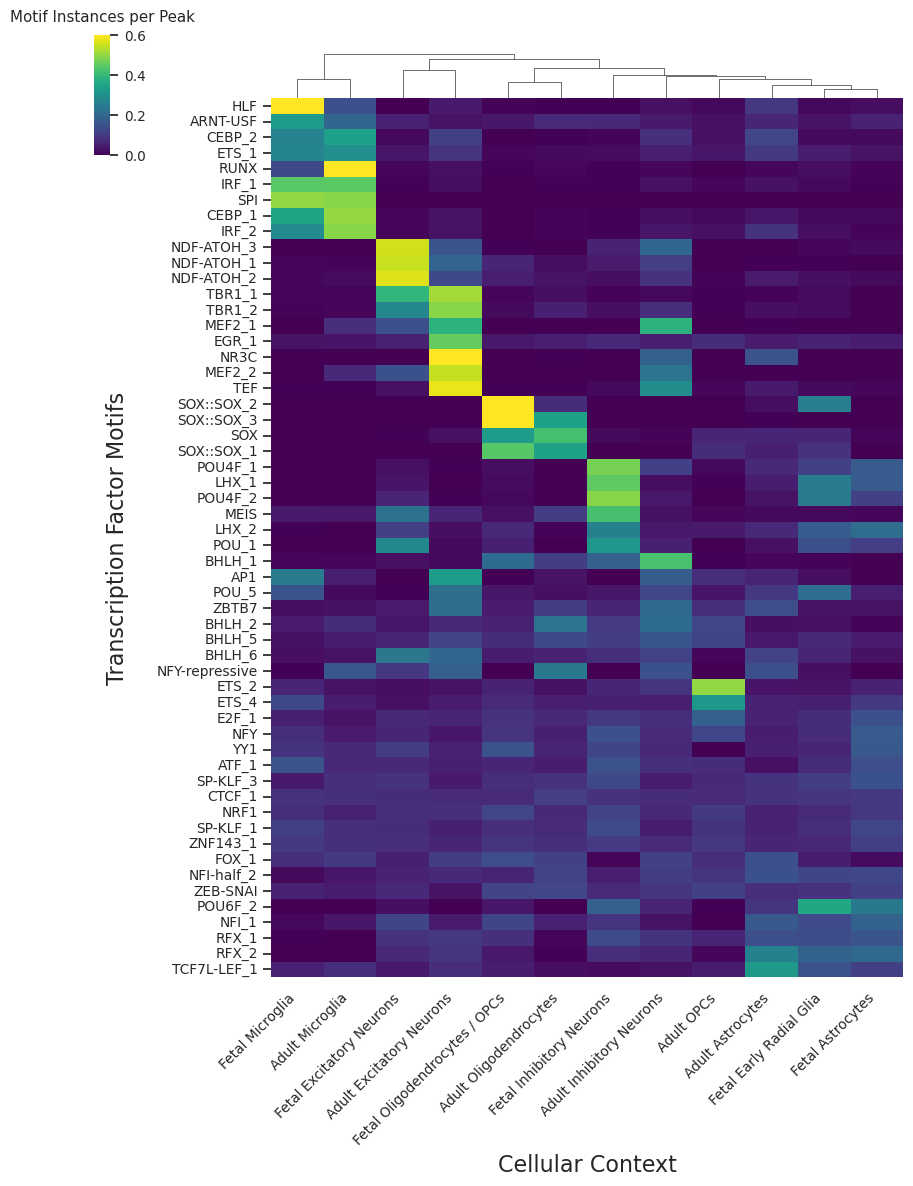

In [52]:
sns.set_theme(style="white", font_scale=0.9)

column_normalized_matrix = final_matrix.div(final_matrix.sum(axis=0), axis=1)

# Generate a clustered heatmap
plt.figure(figsize=(8, 12))
g = sns.clustermap(column_normalized_matrix.T, cmap="viridis", metric="euclidean", method="ward", figsize=(8, 12),
                   row_cluster=True, col_cluster=True, dendrogram_ratio=(0.0, 0.05), vmax=0.6)
g.cax.set_position([-0.2, 0.9, 0.02, 0.1])  # Manually position the color bar

# Move y-axis ticks (row labels) to the left
g.ax_heatmap.yaxis.set_ticks_position("left")
g.ax_heatmap.yaxis.set_label_position("left")
g.ax_heatmap.set_xlabel("Cellular Context", fontsize=16)
g.ax_heatmap.set_ylabel("Transcription Factor Motifs", fontsize=16, labelpad=20)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")

# g.figure.subplots_adjust(top=0.925, right=0.925)

# plt.title("Motif Instances per Peak")
g.cax.set_title("Motif Instances per Peak", pad=10)
plt.savefig(plot_dir + '/motif_hits_per_peak_by_celltype.motif_normalized.all_data_all_patterns.'
            + leiden + '.' + alpha + '.heatmap.pdf',
            format='pdf', bbox_inches="tight")

In [53]:
filtered_matrix.loc[:, 'AP1'].sort_values(ascending=False)


Adult Excitatory Neurons         0.439274
Fetal Microglia                  0.333072
Adult Inhibitory Neurons         0.235501
Adult OPCs                       0.100149
Adult Astrocytes                 0.081042
Adult Microglia                  0.067199
Adult Oligodendrocytes           0.039672
Fetal Early Radial Glia          0.026304
Fetal Oligodendrocytes / OPCs    0.005321
Fetal Inhibitory Neurons         0.002109
Fetal Excitatory Neurons         0.000554
Fetal Astrocytes                 0.000500
Name: AP1, dtype: float64

In [54]:
filtered_matrix.loc[:, 'CTCF_1'].sort_values(ascending=False)


Adult Oligodendrocytes           0.246523
Fetal Astrocytes                 0.213069
Fetal Early Radial Glia          0.206277
Adult Astrocytes                 0.194807
Fetal Inhibitory Neurons         0.192826
Fetal Microglia                  0.190404
Adult Microglia                  0.188051
Fetal Excitatory Neurons         0.165485
Adult Inhibitory Neurons         0.165196
Fetal Oligodendrocytes / OPCs    0.162660
Adult OPCs                       0.162217
Adult Excitatory Neurons         0.161770
Name: CTCF_1, dtype: float64

In [55]:
# Calculate standard deviation and mean across samples
motif_std = filtered_matrix.std(axis=0)
motif_means = filtered_matrix.mean(axis=0)

# Select top 50 by standard deviation
top_std_motifs = motif_std.nlargest(50).index

# Select top 50 by mean
top_mean_motifs = motif_means.nlargest(50).index

# Select top 50 by median
top_median_motifs = filtered_matrix.median(axis=0).nlargest(50).index

# Take the union (removes duplicates if there is overlap)
final_motifs = top_std_motifs.union(top_mean_motifs)
# final_motifs = top_std_motifs.union(top_median_motifs)

# Filter the matrix to only these motifs
final_matrix = filtered_matrix[final_motifs].copy()

# Save or display the final matrix
final_matrix.index.name = "Cellular Context"
final_matrix.columns.name = "Transcription Factor Motif"

final_matrix

Transcription Factor Motif,AP1,ARNT-USF,ATF_1,BHLH_1,BHLH_2,BHLH_5,BHLH_6,CEBP_1,CEBP_2,CTCF_1,...,SP-KLF_3,SPI,TBR1_1,TBR1_2,TCF7L-LEF_1,TEF,YY1,ZBTB7,ZEB-SNAI,ZNF143_1
Cellular Context,,,,,,,,,,,,,,,,,,,,,
Fetal Microglia,0.333072,0.178687,0.232275,0.036361,0.025812,0.011261,0.030196,0.196128,0.088753,0.190404,...,0.015675,0.185606,0.002064,0.000797,0.064422,0.000669,0.023163,0.043835,1.543892,0.023505
Fetal Early Radial Glia,0.026304,0.016180,0.111571,0.020319,0.014949,0.029204,0.076786,0.008296,0.005264,0.206277,...,0.041421,0.000176,0.004860,0.002628,0.178637,0.003638,0.017164,0.066758,2.259457,0.015573
Fetal Oligodendrocytes / OPCs,0.005321,0.019629,0.096427,0.857315,0.032835,0.032091,0.061464,0.001205,0.000474,0.162660,...,0.030027,0.000051,0.002282,0.002282,0.057182,0.000872,0.039578,0.101453,3.173519,0.020693
Fetal Astrocytes,0.000500,0.031833,0.216975,0.006206,0.003799,0.019269,0.034437,0.006600,0.005177,0.213069,...,0.057369,0.000000,0.000257,0.000136,0.130466,0.002346,0.043383,0.066906,3.067224,0.025582
Fetal Inhibitory Neurons,0.002109,0.037435,0.231179,0.759036,0.061626,0.046646,0.102446,0.002210,0.001593,0.192826,...,0.049889,0.000000,0.001593,0.003401,0.021651,0.003027,0.032212,0.143095,1.898300,0.023832
Fetal Excitatory Neurons,0.000554,0.030143,0.105799,0.102249,0.019493,0.026450,0.308285,0.005267,0.004364,0.165485,...,0.032575,0.000143,0.109304,0.043502,0.045558,0.005785,0.028283,0.101131,1.794081,0.017356
Adult OPCs,0.100149,0.012968,0.110895,0.013487,0.075714,0.053601,0.013097,0.006578,0.008265,0.162217,...,0.026642,0.000072,0.000923,0.000577,0.055837,0.002553,0.000202,0.184791,3.017540,0.021651
Adult Oligodendrocytes,0.039672,0.038397,0.071868,0.440959,0.137336,0.056815,0.073649,0.002848,0.001341,0.246523,...,0.032679,0.000220,0.006279,0.008368,0.025224,0.000902,0.015581,0.250250,3.318665,0.018165
Adult Astrocytes,0.081042,0.035121,0.037209,0.045697,0.012560,0.016435,0.155425,0.018566,0.041840,0.194807,...,0.034193,0.000567,0.001632,0.003600,0.381934,0.009545,0.013987,0.332775,2.027879,0.014098


<Figure size 800x1200 with 0 Axes>

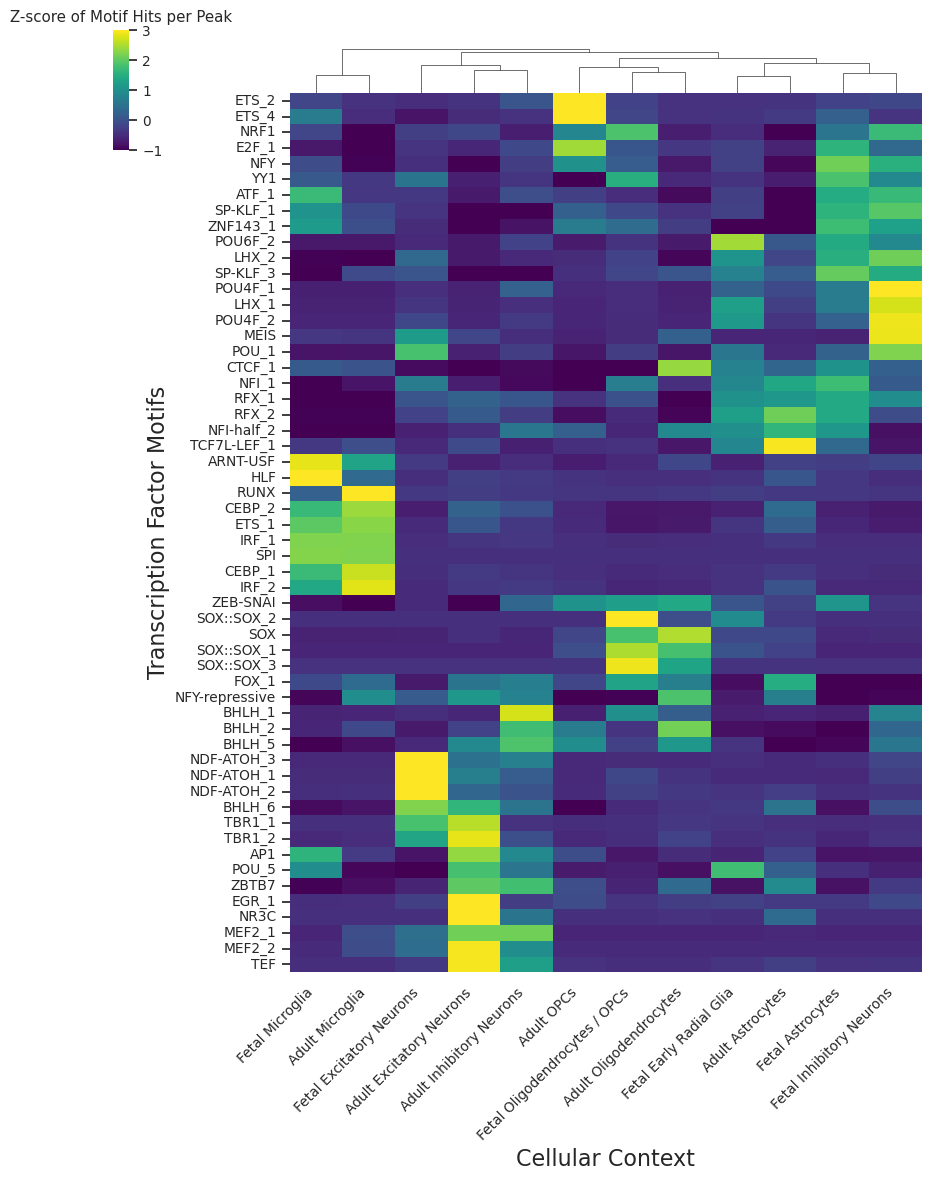

In [56]:
sns.set_theme(style="white", font_scale=0.9)

# Convert to z-scores (row-wise standardization)
z_score_matrix = final_matrix.apply(zscore, axis=0)
# z_score_matrix = column_normalized_matrix.apply(zscore, axis=0)
# quantile_matrix = pd.DataFrame(quantile_transform(final_matrix, axis=0, output_distribution="normal"), 
#                                index=final_matrix.index, 
#                                columns=final_matrix.columns)
# log_matrix = np.log1p(final_matrix)  # log(1 + x) to handle zeros
# z_score_matrix = log_matrix.apply(zscore, axis=0)

# Generate a clustered heatmap
plt.figure(figsize=(8, 12))
g = sns.clustermap(z_score_matrix.T, cmap="viridis", metric="euclidean", method="ward", figsize=(8, 12),
                   row_cluster=True, col_cluster=True, dendrogram_ratio=(0.0, 0.05), vmax=3, vmin=-1)
g.cax.set_position([-0.2, 0.9, 0.02, 0.1])  # Manually position the color bar

# Move y-axis ticks (row labels) to the left
g.ax_heatmap.yaxis.set_ticks_position("left")
g.ax_heatmap.yaxis.set_label_position("left")
g.ax_heatmap.set_xlabel("Cellular Context", fontsize=16)
g.ax_heatmap.set_ylabel("Transcription Factor Motifs", fontsize=16)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")

plt.title("Z-score of Motif Hits per Peak")
plt.savefig(plot_dir + '/motif_hits_per_peak_by_celltype.motif_zscore.all_data_all_patterns.'
            + leiden + '.' + alpha + '.heatmap.pdf',
            format='pdf', bbox_inches="tight")

In [57]:
z_score_matrix

Transcription Factor Motif,AP1,ARNT-USF,ATF_1,BHLH_1,BHLH_2,BHLH_5,BHLH_6,CEBP_1,CEBP_2,CTCF_1,...,SP-KLF_3,SPI,TBR1_1,TBR1_2,TCF7L-LEF_1,TEF,YY1,ZBTB7,ZEB-SNAI,ZNF143_1
Cellular Context,,,,,,,,,,,,,,,,,,,,,
Fetal Microglia,1.586978,2.853624,1.707380,-0.596547,-0.567779,-1.379736,-0.878773,1.706692,1.692025,0.118704,...,-1.333599,2.251463,-0.452761,-0.545090,-0.350978,-0.477609,0.103997,-0.971969,-0.848663,1.171956
Fetal Early Radial Glia,-0.604182,-0.627896,-0.251695,-0.627614,-0.831858,-0.390794,-0.356028,-0.435817,-0.631806,0.754414,...,0.758393,-0.447868,-0.392969,-0.463595,0.838322,-0.403488,-0.414278,-0.823583,0.059851,-0.994300
Fetal Oligodendrocytes / OPCs,-0.754062,-0.554001,-0.497492,0.993373,-0.397035,-0.231702,-0.527944,-0.516704,-0.765131,-0.992482,...,-0.167419,-0.449680,-0.448103,-0.478984,-0.426370,-0.472550,1.522068,-0.598993,1.220389,0.403960
Fetal Astrocytes,-0.788498,-0.292540,1.459050,-0.654947,-1.102935,-0.938366,-0.831195,-0.455170,-0.634241,1.026462,...,2.054332,-0.450426,-0.491407,-0.574519,0.336732,-0.435745,1.850724,-0.822626,1.085431,1.739076
Fetal Inhibitory Neurons,-0.777001,-0.172539,1.689586,0.803038,0.302931,0.570512,-0.068110,-0.505247,-0.734005,0.215690,...,1.446484,-0.450426,-0.462849,-0.429193,-0.796341,-0.418739,0.885671,-0.329427,-0.398691,1.261342
Fetal Excitatory Neurons,-0.788106,-0.328759,-0.345382,-0.468943,-0.721394,-0.542625,2.241449,-0.470376,-0.656879,-0.879347,...,0.039619,-0.448344,1.840761,1.356098,-0.547404,-0.349897,0.546247,-0.601074,-0.531013,-0.507462
Adult OPCs,-0.076733,-0.696714,-0.262672,-0.640847,0.645436,0.953837,-1.070630,-0.455424,-0.548281,-1.010239,...,-0.442464,-0.449376,-0.477167,-0.554897,-0.440374,-0.430581,-1.879617,-0.059514,1.022350,0.665577
Adult Oligodendrocytes,-0.508698,-0.151923,-0.896098,0.187027,2.143586,1.130952,-0.391225,-0.497966,-0.740996,2.366302,...,0.048096,-0.447225,-0.362633,-0.208056,-0.759141,-0.471805,-0.551053,0.364227,1.404673,-0.286543
Adult Astrocytes,-0.213208,-0.222100,-1.458624,-0.578466,-0.889937,-1.094583,0.526324,-0.318679,0.386234,0.295053,...,0.171136,-0.442172,-0.462000,-0.420324,2.955228,-0.256048,-0.688777,0.898440,-0.234171,-1.397158
